In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis import rms, align
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import os

# 获取当前工作目录并定义数据路径
HERE = Path(os.getcwd())
DATA = HERE / 'data'
if not DATA.exists():
    DATA.mkdir(parents=True, exist_ok=True)
print(DATA)

# 加载拓扑和轨迹文件
u = mda.Universe(DATA / "topology.pdb", DATA / "trajectory.xtc")

# 打印系统信息
print(f"Loaded system: {u}")
print(f"Number of atoms: {u.atoms.n_atoms}")

# 打印所有 Residue 名称
unique_resnames = np.unique(u.atoms.resnames)
print("Residues in the system:", unique_resnames)

# 替换 Residue 名称为实际的配体 Residue 名称（例如 UNK）
ligand_resname = "IQO"  # 确保选择正确的配体 Residue 名称

# 定义参考帧，包含蛋白和配体
ref = u.select_atoms("protein or resname 03P")  # 包括配体 Residue 名称
if len(ref) == 0:
    raise ValueError("No atoms found in the reference selection. Please check your selection string.")

# 对齐轨迹到参考帧
aligner = align.AlignTraj(u, ref, select="protein and backbone", in_memory=True)
aligner.run()
print("Trajectory aligned to the reference frame.")

# 选择蛋白质和配体
protein = u.select_atoms("protein")
ligand = u.select_atoms(f"resname {ligand_resname}")

if len(ligand) == 0:
    raise ValueError(f"No atoms found for ligand with resname '{ligand_resname}'. Please check the residue name.")

# 计算蛋白质骨架的 RMSD
rmsd_backbone = rms.RMSD(u, ref, select="protein and backbone", verbose=True)
rmsd_backbone.run()

# 计算蛋白质整体的 RMSD
rmsd_protein = rms.RMSD(u, ref, select="protein", verbose=True)
rmsd_protein.run()

# 计算配体的 RMSD
rmsd_ligand = rms.RMSD(u, ref, select=f"resname {ligand_resname}", verbose=True)
rmsd_ligand.run()

# 提取帧数和 RMSD 数据
frames = range(len(u.trajectory))
rmsd_data = pd.DataFrame({
    "frame": frames,
    "backbone": rmsd_backbone.results.rmsd[:, 2],  # 骨架 RMSD
    "protein": rmsd_protein.results.rmsd[:, 2],    # 整体蛋白 RMSD
    f"resname {ligand_resname}": rmsd_ligand.results.rmsd[:, 2],  # 配体 RMSD
})

# 展示前几行数据
print(rmsd_data.head())

# 可视化 RMSD 数据
plt.figure(figsize=(10, 6))
plt.plot(frames, rmsd_backbone.results.rmsd[:, 2], label="backbone")
plt.plot(frames, rmsd_protein.results.rmsd[:, 2], label="protein")
plt.plot(frames, rmsd_ligand.results.rmsd[:, 2], label=f"resname {ligand_resname}")
plt.xlabel("frame")
plt.ylabel("RMSD (Å)")
plt.title("RMSD of protein and ligand")
plt.legend()
plt.show()


/opt/anaconda3/envs/teachopencadd/lib/python3.8/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


/Users/wangyang/Desktop/Liver_cancer/16-AIDD/10_Molecular_Dynamics_Simulation_Analysis/data


/opt/anaconda3/envs/teachopencadd/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:287: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "


Loaded system: <Universe with 145861 atoms>
Number of atoms: 145861
Residues in the system: ['ALA' 'ARG' 'ASN' 'ASP' 'CL' 'CYS' 'GLN' 'GLU' 'GLY' 'HIS' 'HOH' 'ILE'
 'LEU' 'LYS' 'MET' 'NA' 'PHE' 'PRO' 'SER' 'THR' 'TRP' 'TYR' 'UNK' 'VAL']
Trajectory aligned to the reference frame.


ValueError: No atoms found for ligand with resname 'IQO'. Please check the residue name.

1. 残基 RMSF (Root Mean Square Fluctuation)
RMSF 用于分析每个残基的波动幅度。

In [ ]:
from MDAnalysis.analysis import rms

# 计算每个残基的 RMSF
protein_residues = protein.residues  # 选择蛋白质残基
rmsf = np.zeros(len(protein_residues))

for ts in u.trajectory:
    for i, residue in enumerate(protein_residues):
        residue_atoms = residue.atoms
        rmsf[i] += ((residue_atoms.positions - residue_atoms.center_of_mass())**2).sum(axis=1).mean()

rmsf = np.sqrt(rmsf / len(u.trajectory))

# 可视化 RMSF
plt.figure(figsize=(10, 6))
plt.bar(protein_residues.resids, rmsf, label="RMSF")
plt.xlabel("Residue ID")
plt.ylabel("RMSF (Å)")
plt.title("Root Mean Square Fluctuation (RMSF) by Residue")
plt.show()


2. 角键分析
提取角度变化（例如，主链的二面角 φ 和 ψ），使用 MDAnalysis.analysis.dihedrals 模块。

/opt/anaconda3/envs/teachopencadd/lib/python3.8/site-packages/MDAnalysis/analysis/dihedrals.py:407: UserWarning: Cannot determine phi and psi angles for the first or last residues
  warnings.warn("Cannot determine phi and psi angles for the first "
/opt/anaconda3/envs/teachopencadd/lib/python3.8/site-packages/MDAnalysis/analysis/dihedrals.py:513: DeprecationWarning: The `angle` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.angles` instead
  warnings.warn(wmsg, DeprecationWarning)


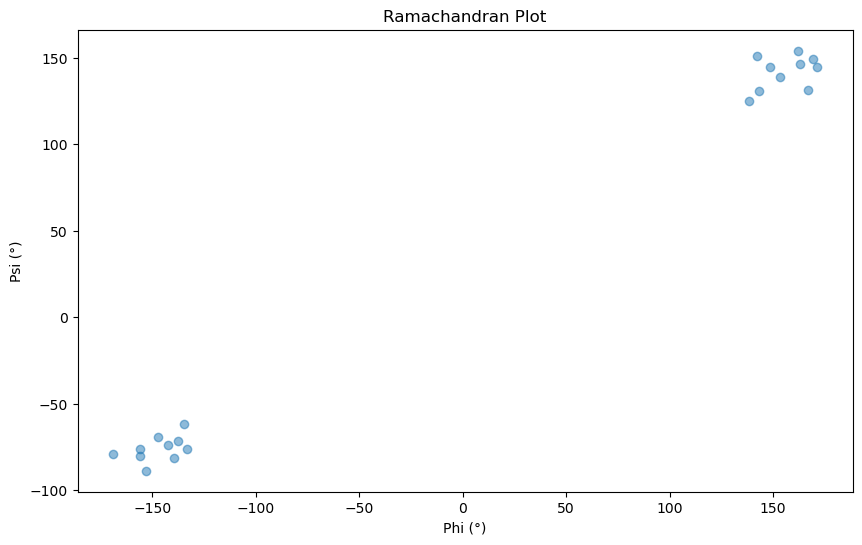

In [8]:
from MDAnalysis.analysis.dihedrals import Ramachandran

# 计算 Ramachandran 图上的主链二面角 φ 和 ψ
rama = Ramachandran(protein).run()

# 提取角度数据
phi_psi_data = rama.angles

# 可视化 Ramachandran 图
plt.figure(figsize=(10, 6))
plt.scatter(phi_psi_data[:, 0], phi_psi_data[:, 1], alpha=0.5)
plt.xlabel("Phi (°)")
plt.ylabel("Psi (°)")
plt.title("Ramachandran Plot")
plt.show()


3. 帧间 RMSD (RMSD Between Frames)
计算帧间 RMSD 矩阵，分析系统在不同时间点的结构变化。

In [ ]:
from MDAnalysis.analysis import rms

# 初始化帧间 RMSD 矩阵
num_frames = len(u.trajectory)
rmsd_matrix = np.zeros((num_frames, num_frames))

# 计算帧间 RMSD
for i, ts1 in enumerate(u.trajectory):
    for j, ts2 in enumerate(u.trajectory):
        if i <= j:  # 只计算对称矩阵的一半
            rmsd_matrix[i, j] = rms.rmsd(ts1.positions, ts2.positions)

# 可视化帧间 RMSD 矩阵
plt.figure(figsize=(10, 8))
plt.imshow(rmsd_matrix, cmap='viridis', origin='lower')
plt.colorbar(label="RMSD (Å)")
plt.xlabel("Frame")
plt.ylabel("Frame")
plt.title("RMSD Between Frames")
plt.show()


4. 残基-原子距离分析
计算每个残基的中心与配体某特定原子之间的距离。

In [9]:
from MDAnalysis.analysis import distances

# 选择配体的某个原子
ligand_atom = ligand.atoms[0]  # 配体的第一个原子，您可以根据需求调整

# 计算每个残基与配体原子的距离
residue_distances = []

for ts in u.trajectory:
    distances_per_frame = []
    for residue in protein_residues:
        com_residue = residue.center_of_mass()  # 残基中心
        distance = distances.distance_array(com_residue, ligand_atom.position)[0, 0]
        distances_per_frame.append(distance)
    residue_distances.append(distances_per_frame)

residue_distances = np.array(residue_distances)

# 可视化距离数据
avg_distances = residue_distances.mean(axis=0)  # 平均距离
plt.figure(figsize=(10, 6))
plt.bar(protein_residues.resids, avg_distances)
plt.xlabel("Residue ID")
plt.ylabel("Average Distance to Ligand (Å)")
plt.title("Residue-Ligand Distances")
plt.show()


AttributeError: center_of_mass() is a method of ResidueGroup, not Residue